# Rolling Origin Cross-Validation: Cross-Validation for Time Series

The goal of this notebook is to help you better understand Rolling Origin Cross-Validation (ROCV) and why it is useful for evaluating time series data.  By completing this notebook you should better understand:

1. Why cross-validation needs to be approached differently in time series than in other types of data.
1. How ROCV works and how to use it using the AMLPF

Here we will begin by loading all the packages needed for this notebook:

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import pkg_resources
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_diabetes
from sklearn.model_selection import (TimeSeriesSplit, cross_val_score)
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from ftk import TimeSeriesDataFrame
from ftk.data import load_dow_jones_dataset
from ftk.transforms import (LagLeadOperator, TimeIndexFeaturizer)
from ftk.model_selection import RollingOriginValidator

## Why do time series need special treatment for cross-validation?

If you are experienced with machine learning but new to time series it may not be immediately obvious why when switching to time series you would need to switch your cross-validation strategy.  After all, when you do something as major as switch from classification to regression you have to change your model's cost function and your evaluation metrics, but you can still use the same cross-validation strategy.

The difference here is the data and specifically whether or not the data are independent and identically distributed (iid).  In most machine learning problems, we assume the data are iid.  However this assumption does not hold for time series data.  We will dig into what it means to be "independent" and "identically distributed" to see why.

To do this we will use two datasets for sake of comparison.  The first dataset will be the diabetes dataset from `scikit-learn`; a standard regression dataset.

In [2]:
# Load in the diabetes dataset
diabetes = load_diabetes()
diabetes_progress = diabetes.target

For comparison we will use a timeseries dataset containing the quarterly revenue for the Dow-Jones industrial companies, using Microsoft's revenue as our specific example.

In [3]:
csv_path = pkg_resources.resource_filename('ftk', '/data/dow_jones')
dow_df = load_dow_jones_dataset(csv_path)
dow_df = pd.concat(dow_df)
msft_df = dow_df.loc[dow_df.grain_index == "MSFT", :]

### Independent

Two events are said to be "independent" if knowing the outcome of one event has no impact on the probability of another event.  An example might be rolling dice.  If we roll a 6 the first time, we are no more or less likely to roll a 6 the next time than if we had rolled a 1 the first time.

The values in a time series are almost never independent since the future values are often determined by the past values.  To illustrate let's look at a toy example where we have two experts trying to predict the value of the blue series below.  Expert 1 (red) says that the series is currently showing exponential growth and they think that will continue.  Expert 2 (green) says that nothing can grow exponentially forever so the series will stabilize at the current rate of growth.

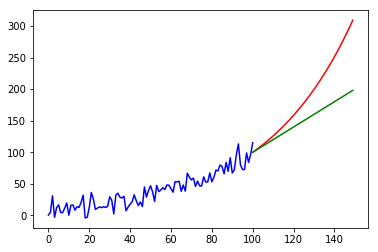

In [4]:
# Values of our candidate series
series = [0.67, 5.15, 31.15, -3.06, 12.25, 16.76, 4.67, 4.55, 11.85, 
          19.68, 0.41, 16.01, 16.6, 8.39, 14.03, 12.66, 20.61, 32.19, -3.89, 
          -2.92, 12.86, 36.35, 26.03, 9.57, 11.62, 13.51, 12.34, 13.84, 
          12.7, 14.27, 29.63, 24.1, 2.41, 32.27, 35.27, 28.97, 27.61, 30.42, 
          7.27, 13.17, 17.78, 21.8, 32.71, 23.31, 15.72, 21.31, 14.11, 
          45.01, 29.01, 39.6, 46.93, 37.26, 22.08, 47.67, 37.79, 40.2, 
          43.97, 40.96, 48.31, 47.81, 42.47, 36.87, 53.43, 52.97, 54.18, 
          38.23, 48.17, 38.52, 67.02, 60.51, 56.22, 59.08, 45.89, 54.55, 
          46.9, 46.56, 61.09, 53, 53.22, 67.33, 53.29, 60.33, 71.76, 70.58, 
          79.75, 77.59, 65.9, 84.03, 69.93, 91.46, 67.26, 72.14, 96.17, 
          113.25, 80.36, 72.65, 72.71, 98.95, 84.08, 96.58, 115.06]
p = plt.plot(series, color='b')

# Predictions from expert 1
prediction1 = [100, 102.33, 104.71, 107.15, 109.65, 112.2, 114.82, 117.49, 
               120.23, 123.03, 125.89, 128.82, 131.83, 134.9, 138.04, 141.25, 
               144.54, 147.91, 151.36, 154.88, 158.49, 162.18, 165.96, 169.82, 
               173.78, 177.83, 181.97, 186.21, 190.55, 194.98, 199.53, 204.17, 
               208.93, 213.8, 218.78, 223.87, 229.09, 234.42, 239.88, 245.47, 
               251.19, 257.04, 263.03, 269.15, 275.42, 281.84, 288.4, 295.12, 
               302, 309.03]
p = plt.plot(range(100,150), prediction1, color='r')

# Predictions from expert 2
prediction2 = [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 
               124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 
               150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 
               176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198]
p = plt.plot(range(100,150),prediction2, color='g')

Based on our current knowledge of the series both experts are equally likely to be correct.  However, now imagine that instead of trying to predict the future we are trying to fill in a gap in the series.

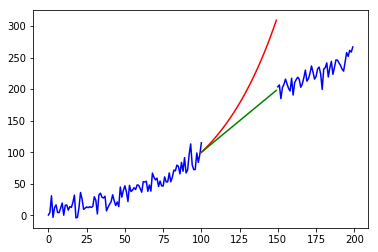

In [5]:
future_vals = [203.67, 206.55, 184.95, 202.32, 207.58, 215.77, 208.35, 201.13, 
197.01, 217.18, 190.57, 210.34, 215.07, 218.76, 215.6, 202.97, 
208.18, 217.9, 230.11, 212.65, 216.59, 224.77, 236.59, 226.9, 
215.86, 220.04, 232.07, 234.87, 223.97, 199.52, 231.77, 233.87, 
241.54, 219.24, 233.72, 244.02, 223.37, 234.27, 246.16, 245.8, 
241.45, 237.45, 231.61, 228.49, 243.26, 257.87, 251.82, 261.38, 
258.58, 266.76]
p = plt.plot(series, color='b')
p = plt.plot(range(100,150),prediction1, color='r')
p = plt.plot(range(100,150),prediction2, color='g')
p = plt.plot(range(150,200),future_vals, color='b')

Now eventhough the initial values and the predictions were the same, we can easily say that the second expert (green) is much more likely to be correct based on the future values of the series.  The fact that we can say this, means the data aren't independent.  In forecasting we are always working in the first scenerio where the future values will be unknown, but standard cross-validation divides the data up more like the second, easier problem.

So how do we know if our data are independent?  One way is to look at the auto-correlation function which measures the correlation between the values of a series at index `i` and the values at index `i-n`.  Let's look at the auto-correlations in our two example datasets; the diabetes dataset and the Microsoft revenue dataset.  An auto-correlation plot shows the correlation between the values `i` and `i-n` on the y-axis and `n` on the x-axis.  The auto-correlation at 0 is always 1 since that is correlation of the value with itself.

Correlation Plots


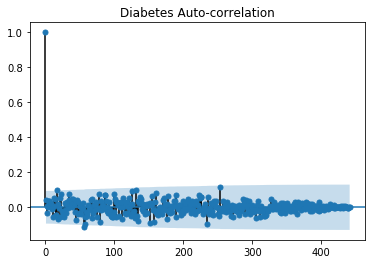

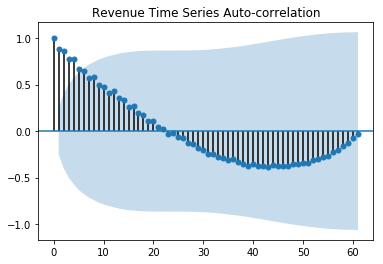

In [6]:
plot_acf(diabetes_progress, title="Diabetes Auto-correlation")
plot_acf(msft_df, title="Revenue Time Series Auto-correlation")
print("Correlation Plots")

Though the diabetes data show no correlation between the rows, the revenue time series shows a high level of correlation well outside the 95% confidence interval for all of the small values of `n`.

### Identically Distributed

In order for data to be "identically distributed" it would have to be able to say that any row of our data is a sample from the same probability distribution.  In other words we don't change our expectation of the target value (for example thinking the value will be higher or lower) based on the row it came from.

We can test if the rows of the standard regression dataset are identically distributed by splitting the rows into groups and use a t-test to see if those rows seem to come from a probability distribution with the same mean as the over all sample.  We begin by doing this with our standard regression diabetes dataset.

Probability sample comes from same distribution: 0.048067141275242475
Probability sample comes from same distribution: 0.23939285458739404
Probability sample comes from same distribution: 0.87159689056665
Probability sample comes from same distribution: 0.5527481291207321
Probability sample comes from same distribution: 0.7313891749909163


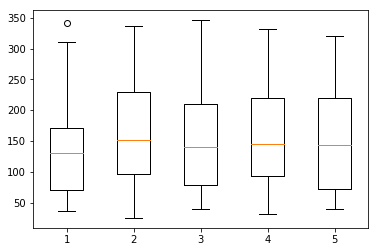

In [7]:
# Split the diabetes into 5 sequential groups
samples = np.array_split(diabetes_progress, 5)
b = plt.boxplot(samples)
# Get the results of the t-test
for s in samples:
    print("Probability sample comes from same distribution: {0}".format(stats.ttest_ind(diabetes_progress, s).pvalue))

Our samples more or less match the overall data distribution in all 5 groups.  Now let's compare this to our revenue time series dataset.

Probability sample comes from same distribution: [  3.05873098e-05]
Probability sample comes from same distribution: [ 0.01588361]
Probability sample comes from same distribution: [ 0.79950575]
Probability sample comes from same distribution: [ 0.03908026]
Probability sample comes from same distribution: [  1.10012914e-05]


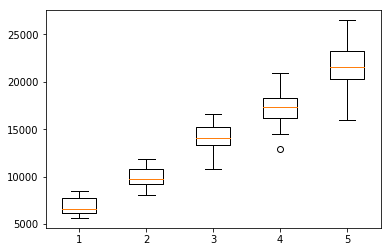

In [8]:
# Split the revenue time series into 5 sequential groups
samples = np.array_split(msft_df.values, 5)
b = plt.boxplot(samples)
# Get the results of the t-test
for s in samples:
    print("Probability sample comes from same distribution: {0}".format(stats.ttest_ind(msft_df, s).pvalue))

We see that the data drifts over time so that the temporal slices of the data we are examining don't match the overall distribution. Because of this, many of the assumptions machine learning models make about the behavior of new samples may not hold in these new data when we are forecasting.

## What is Rolling Origin Cross-Validation and how does it help?

Rolling Origin Cross-Validation can't solve the problem of non-iid data, but it can help compensate for the difficulties it causes by making our cross-validation folds look more like our forecasting data.  For comparison, let's start by looking at what the cross-validation folds would look like using standard 10-fold cross-validaion.

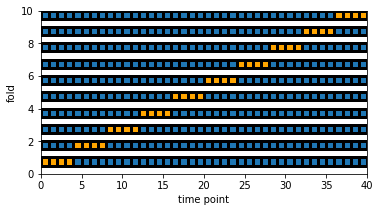

In [9]:
# Set up figure
fig1 = plt.figure(figsize=(20,3))
ax1 = fig1.add_subplot(111, aspect=2)
plt.xlabel("time point")
plt.ylabel("fold")
# Set up series parameters
series_len = 40
n_fold = 10
# Make illstrative plot
plt.xlim(xmax=series_len)
plt.ylim(ymax=n_fold)
for fold in range(n_fold):
    # Plot training data
    for tr in range(series_len):
        ax1.add_patch(patches.Rectangle((tr, 0.5 + fold), 1, 0.5, 
                                        linewidth=3, edgecolor="black"))
    # Plot validating data
    for val in range(fold*series_len//n_fold, (fold + 1)*series_len//n_fold):
        ax1.add_patch(patches.Rectangle((val, 0.5 + fold), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="orange"))

Let's briefly outline the elements of the figure:

* **x-axis**: The rows of boxes stacked next to eachother represent a time series in temporal order
* **y-axis**: Each row represents the same time series in different folds of cross-validation
* **blue boxes**: Time points used to train the model
* **orange boxes**: Timepoints used to validate the model

We note that only the last fold, fold 10, looks like a standard forecasting scenario where all of the training data occurs *before* the data designated as testing data.  There are two main problems this validation schema will cause when data are not iid:

* **Independence Problem**: As discussed in section on independence above, knowing about future values of the series makes it easier to predict past values.  This can lead to problems like over regularizing because the problem appears easier than it is in the validation data.
* **Identically Distributed Problem** This cross-validation strategy samples all the data points equally (each time point is in the testing data exactly once) so their errors will contribute equally to the final model selection.  However since timeseries data frequently aren't identically distributed temporally, the more recent errors one the right of the graph are more likely to be representative for the forecasting error, so they should get greater consideration.

Now lets take a look at Rolling Origin Cross-Validation and see how it differs.

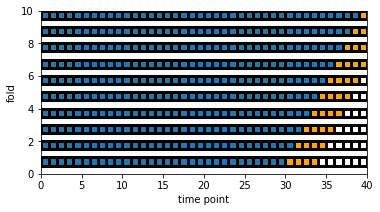

In [10]:
# Set up figure
fig1 = plt.figure(figsize=(20,3))
ax1 = fig1.add_subplot(111, aspect=2)
plt.xlabel("time point")
plt.ylabel("fold")
# Set up series parameters
series_len = 40
always_train_len = 30
horizon = 4
n_fold = 10
# Make illstrative plot
plt.xlim(xmax=series_len)
plt.ylim(ymax=n_fold)
for fold in range(n_fold):
    # Plot training data
    for tr in range(always_train_len + fold):
        ax1.add_patch(patches.Rectangle((tr, 0.5 + fold), 1, 0.5, 
                                        linewidth=3, edgecolor="black"))
    # Plot validating data
    for val in range(tr + 1, tr + horizon + 1):
        ax1.add_patch(patches.Rectangle((val, 0.5 + fold), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="orange"))
    # Plot unused data
    for exc in range(val + 1, series_len):
        ax1.add_patch(patches.Rectangle((exc, 0.5 + fold), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="white"))

As before the x-axis is representing the time point, the y-axis is representing the fold number, and the blue and orange boxes represent the training and validation data respectivly.  Here, the data look more like a forecasting experiment.  The data at the beginning of the series go into the training set while the data closer to the end go into the validation set for each fold.  In this example, we are making a horizon 4 forecast, meaning that our validation data extends 4 time points past the end of the training data.  How does this help with our two problems?  

* **Independence Problem** Any data that is past the end of the validating data is simply ignored and not used to train the model or to select parameters (the white squares).  This avoids making the problem look easier than it is so the parameters selected should generalize better to the future forecasting data.
* **Identically Distributed Problem** The data at the end of the series are the data used to select the model parameters.  Since these data are closer in time to the data we want to forecast, they are more likely to be similarly distributed to our forecasting data.

### Cross-validation folds and origin time

At this point you may have noticed that some of the time points are appearing in the validation set for multiple folds of cross-validation.  For example time point 33 appears in folds 1-4.  This may seem unnecessary since the same error is being evaluated in multiple folds.  The reason this is not only ok but desireable is because of the concept of **origin time**.  Origin time accounts for the fact that we have different knowledge and expectations of a forecast based on when that forecast is made, giving us different features and different forecasts.  For example, when checking the weather forecast you probably have a higher expectation for the accuracy of tomorrow's forecast compared to if you got the forecast from 10 days earlier.  We need our model to be prepared to handle forecasts for a variety of horizons, and giving examples of the same time point at different origin times helps the model do this.  A more complete discussion of origin time and how it impacts features can be found in the notebook *'Constructing Lags and Explaining Origin Times'*, but for now lets look at how origin times impact our cross-validation folds.

To do that, we will first construct some lag features for our example data and then we will split our CV-folds and do our analysis.  Feature construction is where we establish what horizon we want for our forecast using the `max_horizon` parameter because a great many of the features for time series are origin time dependent.  The only parameter the `RollingOriginValidator` needs to set up is `n_splits`, the number of CV folds.  As with the validators in `scikit-learn` calling `split()` on a data set will make a generator returning the row indexes of the training and testing set for each fold.

In [11]:
# Create our origin time dependent features
lag_transform = LagLeadOperator(lags_to_construct={'revenue':list(range(1,5))}, max_horizon=4)
lag_transform.fit(msft_df)
msft_feat = lag_transform.transform(msft_df)
# Set up the Rolling Origin Validator
roll_cv = RollingOriginValidator(n_splits=5)
splits = roll_cv.split(msft_feat)
# Examine the results of splitting the data
print("Max data origin time: {0}".format(msft_feat.origin_time_index.date.max()))
for tr, val in splits:
    print("Fold Time Point Summary:")
    print("    Training data time range: {0} to {1}".format(msft_feat.iloc[tr,:].time_index.date.min(),
                                                            msft_feat.iloc[tr,:].time_index.date.max()))
    print("    Validation data time values: {0}".format(msft_feat.iloc[val,:].time_index.unique().values.astype('M8[D]')))
    print("    Validation data origin time values: {0}".format(\
                                    msft_feat.iloc[val,:].origin_time_index.unique().values.astype('M8[D]')))

Max data origin time: 2015-01-01
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-01-01
    Validation data time values: ['2014-04-01' '2014-07-01' '2014-10-01' '2015-01-01']
    Validation data origin time values: ['2014-01-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-04-01
    Validation data time values: ['2014-07-01' '2014-10-01' '2015-01-01' '2015-04-01']
    Validation data origin time values: ['2014-04-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-07-01
    Validation data time values: ['2014-10-01' '2015-01-01' '2015-04-01']
    Validation data origin time values: ['2014-07-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-10-01
    Validation data time values: ['2015-01-01' '2015-04-01']
    Validation data origin time values: ['2014-10-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2015-01-01
    Validation data time values: ['201

So what do we observe in these splits?  

* The training data always includes data beginning at the earliest time point and extends forward in time.  
  * The end time point for the training data increases in each fold meaning the training data gets larger.  
* The validation data always starts as the next timepoint after the end of the training data and in the first few folds holds four different time points, the `max_horizon` from our feature set.  
  * In later folds the number of time points in the validation set holds shrinks.  This is because we have reached the end of the time points available in the training data.  
* There is only ever one validation origin time present and that time matches the last time point of the training data.  In other words the features for the validation data were generated as of the end time point of the training data; just like a real forecast.
  * This means that while the same *time point* may appear in multiple different folds, it will always be from a different origin time.
  
Some questions for you:

1. What happens if we change the data frame from just being the Microsoft time series `msft_df` to being the entire Dow Jones dataset `dow_df`?  Did anything change about the time values for the splits?  If so, why, if not, why not?
1. What happens if you change the `max_horizon` of the `LagLeadOperator` to be a smaller value like 2?
1. What happens if you make the `max_horizon` of the `LagLeadOperator` a large value like 8?  What if you also make the `n_splits` value of the `RollingOriginValidator` a larger value like 10?  What does that mean about the relationship between the horizon of your features and the number of splits of your validator?

### Spreading out folds with the `n_step` parameter

One thing you may have noticed here is that in order to get an example of a horizon `n` forecast, you need at least `n` folds of cross-validation.  That is all well and good for short horizons like 4, but can become very limiting if you want to get a year's worth of forecasts for daily data.  The `n_step` parameter allows us to reduce the number of folds needed to get these longer horizons by increasing the number of steps forward the validator takes after each fold of cross-validation.  Let's see what it does when we set `n_step` to 2.

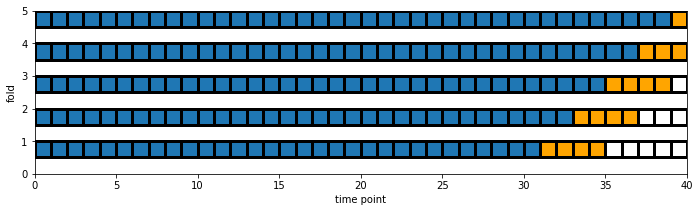

In [12]:
# Set up figure
fig1 = plt.figure(figsize=(20,3))
ax1 = fig1.add_subplot(111, aspect=2)
plt.xlabel("time point")
plt.ylabel("fold")
# Set up series parameters
series_len = 40
always_train_len = 30
horizon = 4
n_fold = 5
# Make illstrative plot
plt.xlim(xmax=series_len)
plt.ylim(ymax=n_fold)
for fold in range(1, 10, 2):
    # Plot training data
    for tr in range(always_train_len + fold):
        ax1.add_patch(patches.Rectangle((tr, 0.5 + (fold - 1)/2), 1, 0.5, 
                                        linewidth=3, edgecolor="black"))
    # Plot validating data
    for val in range(tr + 1, tr + horizon + 1):
        ax1.add_patch(patches.Rectangle((val, 0.5 + (fold - 1)/2), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="orange"))
    # Plot unused data
    for exc in range(val + 1, series_len):
        ax1.add_patch(patches.Rectangle((exc, 0.5 + (fold - 1)/2), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="white"))

Here we see that by moving each fold of cross-validation two steps forward with each fold instead of 1 we can get many examples of each all 4 horizons with only 5 folds of cross-validation.  Below we have an example of setting the `n_step` parameter in in `RollingOriginValidator`.

**Exercise**: Below we have an example of using `n_step` to increase the step size between cross-validation folds.  How big do we need to make `n_step` to get all 15 horizons?  Try adjusting the value below to check your answer.

In [13]:
# Create our origin time dependent features with a long horizon
lag_transform = LagLeadOperator(lags_to_construct={'revenue':list(range(1,5))}, max_horizon=15)
lag_transform.fit(msft_df)
msft_feat = lag_transform.transform(msft_df)
# Set up the Rolling Origin Validator
n_step = 1  ### Change this parameter to get all our horizons in the validation data
roll_cv = RollingOriginValidator(n_splits=5, n_step=n_step)
splits = roll_cv.split(msft_feat)
# Examine the results of splitting the data
print("Max data origin time: {0}".format(msft_feat.origin_time_index.date.max()))
for tr, val in splits:
    print("Fold Time Point Summary:")
    print("    Training data time range: {0} to {1}".format(msft_feat.iloc[tr,:].time_index.date.min(),
                                                            msft_feat.iloc[tr,:].time_index.date.max()))
    print("    Number of validation data time values: {0}".format(len(msft_feat.iloc[val,:].time_index.unique())))

Max data origin time: 2015-01-01
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-01-01
    Number of validation data time values: 5
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-04-01
    Number of validation data time values: 4
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-07-01
    Number of validation data time values: 3
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-10-01
    Number of validation data time values: 2
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2015-01-01
    Number of validation data time values: 1


### Cross-validation without origin time

Most of the time we create features for our data they will have an origin time since like lags those features values will depend on when they are generated.  However there are a few features we can make for our time series which do not depend on origin time.  One example of this is the `TimeIndexFeaturizer` which creates features using information like "day of week" and "month of year".  Since these values can be computed with perfect accuracy at any amount of time into the future, making a new row of data for each origin time would be redundant.

If you happen to be making a model with these types of features `RollingOriginValidator` has a `max_horizon` option which will still allow you to do multi horizon rolling origin cross-validation.  We can use this parameter just like we did in the lag operator to get a 4 horizon forecast even though we don't have any horizon dependant features.

In [14]:
# Create our origin time independent features
time_transform = TimeIndexFeaturizer()
time_transform.fit(msft_df)
feat_no_origin = time_transform.transform(msft_df)
# Set up the Rolling Origin Validator
roll_cv = RollingOriginValidator(n_splits=5, max_horizon=4)
splits = roll_cv.split(feat_no_origin)
# Examine the results of splitting the data
for tr, val in splits:
    print("Fold Time Point Summary:")
    print("    Training data time range: {0} to {1}".format(feat_no_origin.iloc[tr,:].time_index.date.min(),
                                                            feat_no_origin.iloc[tr,:].time_index.date.max()))
    print("    Validation data time values: {0}".format(feat_no_origin.iloc[val,:].time_index.unique().values.astype('M8[D]')))

Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-01-01
    Validation data time values: ['2014-04-01' '2014-07-01' '2014-10-01' '2015-01-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-04-01
    Validation data time values: ['2014-07-01' '2014-10-01' '2015-01-01' '2015-04-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-07-01
    Validation data time values: ['2014-10-01' '2015-01-01' '2015-04-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2014-10-01
    Validation data time values: ['2015-01-01' '2015-04-01']
Fold Time Point Summary:
    Training data time range: 2000-01-01 to 2015-01-01
    Validation data time values: ['2015-04-01']


Using the `max_horizon` parameter we were able to get the same time indices into the training and testing data as we did in our data with origin times.  Where as before each cross-validation fold actually contained different rows of data (corresponding to the same time index but different origin times), this time whenever we see the same time index in a fold it is actually corresponding to the same row of data.  Still, we would expect to get different forecasts in each fold because the training data is different when training data closer to the time we are trying to forecast becomes available, our forecast for that time should improve.

Questions:

1. What happens if we use the `max_horizon` parameter on data that has an origin time?  Try it out by `feat_no_origin` in the code above for `msft_feat`.  
1. What happens if you make the `max_horizon` for the `RollingOriginValidator` smaller than the `LagLeadOperator` (e.g. set it to 2)?  
1. How about if you make it bigger (e.g. set it to 6)?  Why was the behavior for making the `max_horizon` larger for the `RollingOriginValidator` different than when you made it smaller?

### Using the `RollingOriginValidator` with `scikit-learn` functions

The `RollingOriginValidator` was designed to be interoperable with `scikit-learn` functions which take validators like `GridSearchCV` and `cross-val-score` so long as the X input is a `TimeSeriesDataFrame`.  For documentation on `scikit-learn` validators, please see [their documentation page on the topic](http://scikit-learn.org/stable/modules/cross_validation.html).  For example, we can get backtesting results for a linear regression model on out dataset we built as follows.

In [15]:
# Specify our model
lm = LinearRegression()
# Copy our feature data and clean it up a little
X = msft_feat.copy()
X.dropna(inplace=True)
X.ts_value_colname = None
# Pull out the target and remove the target from the training data
y = X['revenue']
X.drop('revenue', axis=1, inplace=True)
# Evaluate the model performance
roll_cv = RollingOriginValidator(n_splits=8)
scores = cross_val_score(lm, X, y, cv=roll_cv)
print(scores)

[ -2.97785948e-01  -3.13795599e-01  -1.90650117e-02  -1.68772771e-02
  -1.30665433e-01  -1.09135555e+00  -3.92518751e+02   0.00000000e+00]


When the `RollingOriginValidator` is used in conjunction with `ftk.model_selection.TSGridSearchCV` there are a lot of extra benefits you can get like automated backtesting at negligable computational cost and forecast prediction intervals, but that is another notebook!

## An aside: Doesn't `scikit-learn` already have time series cross-validation?

For those of you familiar with `scikit-learn`, you may be aware that that library already has a function called `TimeSeriesSplit` which is their proposed solution for time series cross-validation.  Let's take a look at how `TimeSeriesSplit` divides up the data.

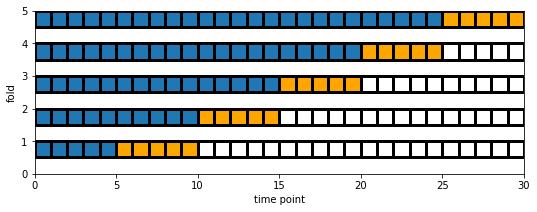

In [16]:
# Set up the plot
fig2 = plt.figure(figsize=(20,3))
ax2 = fig2.add_subplot(111, aspect=2)
n_fold = 5
series_len = 30
plt.xlabel("time point")
plt.ylabel("fold")
# Create a set of values to split.  Here we will simply use the values
# from 0 to series_len so it will be easy to map the value to the order.
values = list(range(series_len))
skl_tscv = TimeSeriesSplit(n_splits=n_fold)
# Make illstrative plot
plt.xlim(xmax=series_len)
plt.ylim(ymax=n_fold)
for (tr, val), fold in zip(skl_tscv.split(values), range(n_fold)):
    for t in tr:
        ax2.add_patch(patches.Rectangle((values[t], 0.5 + fold), 1, 0.5, 
                                        linewidth=3, edgecolor="black"))
    for v in val:
        ax2.add_patch(patches.Rectangle((values[v], 0.5 + fold), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="orange"))
    for exc in range(v + 1, series_len):
        ax2.add_patch(patches.Rectangle((values[exc], 0.5 + fold), 1, 0.5, linewidth=3, 
                                        edgecolor="black", facecolor="white"))

So what did scikit-learn's function do here?  It split our data up into `n_splits + 1` groups like it would for k-fold cross-validation.  In fact, `TimeSeriesSplit` actually inherits from the `KFold` validator.  Then for each fold `f`, it took the data in groups `<= f` and assigned them to the training data and took the data in group `f + 1` and assigned it to testing data.  This has a few draw backs.

1. The horizon of the forecast and the number of folds of cross-validation are linked where `horizon=series_length/(n_fold + 1)`.  In other words, in the example above where the series length is 30 if you want to make a horizon two forecast, you have to have your number of folds be 14.
1. Each time point only appears in one fold so we can't see the impact of forecasting the same data from different horizons.
1. There is more or less equal sampling across the entire series, so the change in distribution of values over time is not accounded for.
1. The rows are split from top to bottom rather than having some indicator for the order of the series (like the `TimeSeriesDataFrame` `time_index` column).  This means the series has to be input in sorted order.
1. It is unlikely you can combine many series with different start and stop times in a single model.  The different lengths of the series will mean that there will be different numbers of rows corresponding to each time point.  Since each fold of CV has to be equal size, this means we can't form the groups splitting on time.
1. There is no way to account for the origin time of the features.

The `RollingOriginValidator` overcomes all of these limitations allowing for better model tuning in time series data.